# Syria Land Cover Land Use Analytics

## Overview

This notebook analyzes land cover trends specifically for croplands in Syria over time using spatial imagery datasets and also attempt to assess the pre and post conflict environmental impacts.

## Data

The following datasets are utilized in this analysis for calculating and mapping crop productivity over the past years:

1. **Dynamic World Dataset**:
   - **Source**: [Dynamic World - Google and the World Resources Institute (WRI)](https://dynamicworld.app/) 
   - **Description**:The Dynamic World dataset provides a near real-time, high-resolution (10-meter) global land cover classification. It is derived from Sentinel-2 imagery and utilizes machine learning models to classify land cover into nine distinct classes, including water, trees, grass, crops, built areas, bare ground, shrubs, flooded vegetation, and snow/ice. The dataset offers data with minimal latency, enabling near-immediate analysis and decision-making.
   - **Spatial Resolution**: 10 meters.
   - **Temporal Coverage**: Data is available since mid-2015, updated continuously as Sentinel-2 imagery becomes available capturing near Real-time.
   - **Use Case**: Dynamic World is valuable for monitoring land cover changes, assessing deforestation, urban expansion, agricultural land use changes, and disaster impacts (e.g., flooding). Its high spatial and temporal resolution enables detailed tracking of land cover dynamics for environmental management and planning.

2.**MODIS Land Cover Dataset**:
   - **Source:** NASA's Moderate Resolution Imaging Spectroradiometer [MODIS](https://modis.gsfc.nasa.gov/data/) Land Cover on Terra and Aqua satellites.
   - **Description:** The MODIS Land Cover dataset (MCD12Q1) provides annual global land cover classification at 500-meter resolution. It includes several classification schemes, such as the International Geosphere-Biosphere Programme (IGBP), University of Maryland (UMD), and MODIS-derived classifications. The dataset also includes a LC_Type2 band that represents vegetation and land cover types based on the University of Maryland classification scheme [LC_Type2 Class]
   - **Spatial Resolution:** 500 meters.
   - **Temporal Coverage:** Annual classifications are available from 2001 to the present.
   - **Use Case:** The dataset is widely used for global and regional land cover analysis, biodiversity assessments, agricultural monitoring (focusing on cropland classification using LC_Type2), ecosystem studies, and climate change research. The annual updates enable tracking of land cover changes over time, which supports environmental policy planning and implementation.
   
3. **Administrative Boundaries (HDX)**:
   - **Source**: Humanitarian Data Exchange [HDX](https://data.humdata.org/).
   - **Description**: Geographic boundaries used for spatial aggregation and administrative analysis, such as calculating productivity metrics by region (e.g., governorate or district).
   - **Use Case**: The administrative boundaries are used to aggregate EVI statistics by region and facilitate reporting at various administrative levels.

4. **ACLED Conflict Data**:
   - **Source**: [ACLED](https://acleddata.com/data/) provides real-time data on conflict events worldwide.
   - **Description**: Conflict data was sourced from the ACLED database, which provides detailed records of events such as battles, protests, and other violent activities, including attributes like event type, date, and number of fatalities.The dataset was loaded as a CSV and converted to a GeoDataFrame (acled_gdf), with geometries representing the event locations.
   -**Use Case**: Used for conflict monitoring, risk assessment, and informing humanitarian policies.


In [1]:
import ee
import geopandas as gpd
import os
import json
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geemap

In [2]:
ee.Authenticate()
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
base_path = (
    "C:\\Users\\ishaa\\OneDrive\\Desktop\\DataLab\\Syria\\syria-economic-monitor"
)

In [4]:
sys.path.append(
    "C:/Users/ishaa/OneDrive/Desktop/DataLab/Syria/syria-economic-monitor/GEE_Zonal/src/gee_zonal"
)  # Replace with the actual path to the GEE_Zonal repository

In [5]:
from gee_helpers import gpd_to_gee

In [6]:
# loading boundaries
adm0_path = os.path.join(base_path, "data", "boundaries", "syr_admin0.shp")
syr_adm0 = gpd.read_file(adm0_path)
syr_adm0.to_file("syria_boundary.geojson", driver="GeoJSON")
with open("syria_boundary.geojson") as f:
    syr_geojson = json.load(f)
syria_geometry = ee.Geometry(syr_geojson["features"][0]["geometry"])


adm1_path = os.path.join(base_path, "data", "boundaries", "syr_admin1.shp")
syr_adm1 = gpd.read_file(adm1_path)
syr_adm1.to_file("syria_boundary1.geojson", driver="GeoJSON")
with open("syria_boundary1.geojson") as f:
    syr_geojson_adm1 = json.load(f)
syr_adm1_geometry = ee.Geometry(syr_geojson_adm1["features"][0]["geometry"])

In [7]:
coords = syria_geometry.centroid().coordinates().getInfo()
centx, centy = coords[0], coords[1]
# print(centx, centy)

## Syria Land Cover

::::{tab-set}
:::{tab-item} 2000 - 2010
![Syria MODIS Land Use Cover.png](../../docs/images/agriculture/syria_modis_2000_2010_landcover.png)
:::
:::{tab-item} 2011 - 2015
![Syria MODIS Lad cover 2011-2015.png](../../docs/images/agriculture/syria_modis_2011_2015_landcover.png)
:::
:::{tab-item} 2016 - Present
![Syria MODIS Land Use Cover.png](../../docs/images/agriculture/syria_dynamicworld_cover_2016_2023.png)
:::

In [6]:
start_date = ee.Date("2016-01-01")
end_date = ee.Date("2024-10-31")

dw_collection = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filterDate(start_date, end_date)
    .filterBounds(syria_geometry)
)

# Create a mode composite for 2011-2023
dw_2011_2023 = dw_collection.filterDate("2019-01-01", "2023-12-31")
mode_composite = dw_2011_2023.select("label").reduce(ee.Reducer.mode())

# Visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 6)
vis_params = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}
Map.addLayer(mode_composite.clip(syria_geometry), vis_params, "DW 2023 Mode Composite")

# Define a legend for the land cover types
legend_dict = {
    "Water": "#419BDF",
    "Trees": "#397D49",
    "Grass": "#88B053",
    "Flooded Vegetation": "#7A87C6",
    "Crops": "#E49635",
    "Shrubland": "#DFC35A",
    "Built Area": "#C4281B",
    "Bare Ground": "#A59B8F",
    "Snow and Ice": "#B39FE1",
}

# Add a legend to the map
Map.add_legend(title="Land Cover Classes", legend_dict=legend_dict)

Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
# Export the mode composite to Google Drive
dw_export_task = ee.batch.Export.image.toDrive(
    image=mode_composite.clip(syria_geometry),
    description="DW_Mode_Composite_2016_2024",
    folder="EarthEngineExports",  # Specify a folder in Google Drive
    scale=50,  # Dynamic World resolution is 10m
    region=syria_geometry,
    fileFormat="GeoTIFF",
    maxPixels=1e13,  # Adjust as needed for large regions
)

dw_export_task.start()
print("Export task started. Check the Tasks tab in Earth Engine or your Google Drive.")

Export task started. Check the Tasks tab in Earth Engine or your Google Drive.


In [ ]:
import rasterio
from matplotlib.colors import ListedColormap
import numpy as np

# Path to the downloaded GeoTIFF file
geo_tiff_path = r"path_to_downloaded_tiff_file.tif"

# Define the colormap for Dynamic World land cover classes
landcover_cmap = ListedColormap(
    [
        "#419BDF",  # Water
        "#397D49",  # Trees
        "#88B053",  # Grass
        "#7A87C6",  # Flooded Vegetation
        "#E49635",  # Crops
        "#DFC35A",  # Shrubland
        "#C4281B",  # Built Area
        "#A59B8F",  # Bare Ground
        "#B39FE1",  # Snow and Ice
    ]
)

# Define the land cover classes for the legend
legend_labels = [
    "Water",
    "Trees",
    "Grass",
    "Flooded Vegetation",
    "Crops",
    "Shrubland",
    "Built Area",
    "Bare Ground",
    "Snow and Ice",
]

# Open the GeoTIFF file using rasterio
with rasterio.open(geo_tiff_path) as src:
    landcover_data = src.read(1)  # Read the first band
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Plot the land cover map
plt.figure(figsize=(12, 8))
plt.imshow(landcover_data, cmap=landcover_cmap, extent=extent)
plt.colorbar(
    label="Land Cover Classes", ticks=np.arange(0.5, 9.5, 1), values=np.arange(9)
)
plt.title("Dynamic World Land Cover Mode Composite (2011-2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Create a custom legend
from matplotlib.patches import Patch

legend_patches = [
    Patch(color=landcover_cmap(i), label=label) for i, label in enumerate(legend_labels)
]
plt.legend(handles=legend_patches, loc="lower right", title="Land Cover Classes")

plt.show()

In [8]:
# MODIS Data for EVI
start_period = ee.Date("2011-01-01")
end_period = ee.Date("2024-08-31")

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_period, end_period)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")


# ----------------------BITWISE MASKING---------------------------------------
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

"""dea = ee.ImageCollection(
    "projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask"
).mosaic()
crop_data_dea = dea.select("b1").rename("crop").clip(syria_geometry)
crop_data_viz_dea = crop_data_dea.mask(crop_data_dea.gt(0))"""

worldcover = ee.Image("ESA/WorldCover/v200/2021")
cropland_mask = worldcover.eq(40).rename("crop").clip(syria_geometry)
cropland_mask_viz = cropland_mask.mask(cropland_mask)

scale_factor = 0.0001


# apply cropland mask to imageCollection
def cropmask(img):
    return (
        img.updateMask(cropland_mask).multiply(scale_factor).clip(syria_geometry)
    )  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)

In [ ]:
"""# Define visualization parameters for the crop mask
crop_data_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['529400'] # Set the color for crop areas to green
}

# Create a Folium map centered over Sudan
#map_center = [12.8628, 30.2176] 
map_center = [centy, centx]  # Approximate center of Sudan
m = folium.Map(location=map_center, zoom_start=6)

# Ensure there are no Timestamp objects
for col in syr_adm1.columns:
    if pd.api.types.is_datetime64_any_dtype(syr_adm1[col]):
        syr_adm1[col] = syr_adm1[col].astype(str)  # Convert Timestamps to strings

# Add the boundaries to Folium map with transparent fill and blue border
folium.GeoJson(
    syr_adm1, 
    name="adm2 boundaries",
    style_function=lambda x: {
        'fillColor': 'gray',  # Transparent fill
        'color': 'darkgray',  # Blue boundary color
        'weight': 1  # Thickness of boundary lines
    }
).add_to(m)

# Add labels for each adm2 region (district-level or equivalent)
for _, region in syr_adm1.iterrows():
    folium.Marker(
        location=[region.geometry.centroid.y, region.geometry.centroid.x],  # Centroid of the region
        popup=region['NAME_EN'],  # Column containing adm2 name (adjust if necessary)
        icon=folium.DivIcon(html=f'<div style="font-size: 12px; font-weight: bold; color: brown;">{region["NAME_EN"]}</div>')
    ).add_to(m)

# Overlay the crop extent from LGRIP30 using TileLayer with Map ID
crop_map_id = cropland_mask_viz.getMapId(crop_data_viz_params)
folium.TileLayer(
    tiles=crop_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='ESA Worldcover Crop Extent',
    overlay=True,
    control=True
).add_to(m)

# Add layer control to the map (to toggle boundaries and crop extent)
folium.LayerControl().add_to(m)

# Save or display the map
#m.save("sudan_crop_extent_dea_adm1.html")
m"""

In [9]:
# Define the time period
start_year = 2000
end_year = 2010

# Load the MODIS Land Cover Type dataset and filter for the desired years
modis_lc = (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .filter(ee.Filter.calendarRange(start_year, end_year, "year"))
    .filterBounds(syria_geometry)
    .select("LC_Type2")
)  # LC_Type1 is the IGBP classification

# Apply the mode reducer to get the most common land cover type for each pixel over the time period
mode_lc_2000_2010 = modis_lc.reduce(ee.Reducer.mode()).clip(syria_geometry)

# Define visualization parameters for the land cover classes
# You can adjust the colors based on MODIS IGBP classes
landcover_viz = {
    "min": 1,
    "max": 17,
    "palette": [
        "180fbe",
        "086a10",
        "54a708",
        "78d203",
        "009900",
        "c6b044",
        "dcd159",
        "dade48",
        "fbff13",
        "b6ff05",
        "27ff87",
        "c24f44",
        "a5a5a5",
        "ff6d4c",
        "828188",
        "f9ffa4",
        "1c0dff",
    ],
}

legend_dict = {
    "Water Bodies": "#1c0dff",
    "Evergreen Needleleaf Forests": "#05450a",
    "Evergreen Broadleaf Forests": "#086a10",
    "Deciduous Needleleaf Forests": "#54a708",
    "Deciduous Broadleaf Forests": "#78d203",
    "Mixed Forests": "#009900",
    "Closed Shrublands": "#c6b044",
    "Open Shrublands": "#dcd159",
    "Woody Savannas": "#dade48",
    "Savannas": "#fbff13",
    "Grasslands": "#b6ff05",
    "Permanent Wetlands": "#27ff87",
    "Croplands": "#c24f44",
    "Urban and Built-up Lands": "#a5a5a5",
    "Cropland/Natural Vegetation Mosaics": "#ff6d4c",
    "Non-Vegetated Lands": "#f9ffa4",
}

# Create a map centered on your region of interest (e.g., Syria)
Map = geemap.Map()
Map.centerObject(
    ee.Geometry.Point([centx, centy]), 6
)  # Center on Syria, adjust as needed

# Add the mode land cover layer to the map
Map.addLayer(mode_lc_2000_2010, landcover_viz, "Mode Land Cover (2000-2010)")

# Add a legend to the map
Map.add_legend(title="Land Cover Types (2000-2010)", legend_dict=legend_dict)

# Display the map
Map

Map(center=[35.00473784303624, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [10]:
# Define the time period
start_year = 2011
end_year = 2015

# Load the MODIS Land Cover Type dataset and filter for the desired years
modis_lc = (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .filter(ee.Filter.calendarRange(start_year, end_year, "year"))
    .filterBounds(syria_geometry)
    .select("LC_Type2")
)  # LC_Type1 is the IGBP classification

# Apply the mode reducer to get the most common land cover type for each pixel over the time period
mode_lc_2011_2015 = modis_lc.reduce(ee.Reducer.mode()).clip(syria_geometry)

# Define visualization parameters for the land cover classes
# You can adjust the colors based on MODIS IGBP classes
landcover_viz = {
    "min": 1,
    "max": 17,
    "palette": [
        "180fbe",
        "086a10",
        "54a708",
        "78d203",
        "009900",
        "c6b044",
        "dcd159",
        "dade48",
        "fbff13",
        "b6ff05",
        "27ff87",
        "c24f44",
        "a5a5a5",
        "ff6d4c",
        "828188",
        "f9ffa4",
        "1c0dff",
    ],
}

legend_dict = {
    "Water Bodies": "#1c0dff",
    "Evergreen Needleleaf Forests": "#05450a",
    "Evergreen Broadleaf Forests": "#086a10",
    "Deciduous Needleleaf Forests": "#54a708",
    "Deciduous Broadleaf Forests": "#78d203",
    "Mixed Forests": "#009900",
    "Closed Shrublands": "#c6b044",
    "Open Shrublands": "#dcd159",
    "Woody Savannas": "#dade48",
    "Savannas": "#fbff13",
    "Grasslands": "#b6ff05",
    "Permanent Wetlands": "#27ff87",
    "Croplands": "#c24f44",
    "Urban and Built-up Lands": "#a5a5a5",
    "Cropland/Natural Vegetation Mosaics": "#ff6d4c",
    "Non-Vegetated Lands": "#f9ffa4",
}

# Create a map centered on your region of interest (e.g., Syria)
Map = geemap.Map()
Map.centerObject(
    ee.Geometry.Point([centx, centy]), 6
)  # Center on Syria, adjust as needed

# Add the mode land cover layer to the map
Map.addLayer(mode_lc_2011_2015, landcover_viz, "Mode Land Cover (2000-2010)")

# Add a legend to the map
Map.add_legend(title="Land Cover Types (2000-2010)", legend_dict=legend_dict)

# Display the map
Map

Map(center=[35.00473784303624, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
"""task_2000_2010 = ee.batch.Export.image.toDrive(
    image=mode_lc_2000_2010,
    description='LandCoverMode_2000_2010',
    folder='EarthEngineExports',  # Optional: specify the Google Drive folder
    scale=500,  # Resolution in meters
    region=syria_geometry,
    fileFormat='GeoTIFF',
    maxPixels=1e13  # Increase if your region is large
)

task_2011_2015 = ee.batch.Export.image.toDrive(
    image=mode_lc_2011_2015,
    description='LandCoverMode_2011_2015',
    folder='EarthEngineExports',  # Optional: specify the Google Drive folder
    scale=500,  # Resolution in meters
    region=syria_geometry,
    fileFormat='GeoTIFF',
    maxPixels=1e13  # Increase if your region is large
)

task_2000_2010.start()
task_2011_2015.start()"""

## Cropland Area Yearly Trends


::::{tab-set}
:::{tab-item} MODIS 2001 - 2015
![cropland_change_2024.png](../../docs/images/agriculture/cropland_area_MODIS_yearly_2001_2015.png)
:::
:::{tab-item} DW 2016-2024
![cropland_change_2023.png](../../docs/images/agriculture/cropland_area_DW_yearly_2016_2024.png)
::::

## Cropland Area change Map

### Methodology

1. **Data Filtering and Preparation:** The **Dynamic World dataset**  and (MODIS for 2010-2011 map) is filtered for the study area (Syria) and two time periods (2016 and 2023/2024). Binary mosaics are created for each period to isolate the cropland class (`label == 4`). The comparison is made from 2016 since this dataset is available from June 2015. 

2. **Change Detection:** Cropland **gain** (areas transitioning from non-cropland to cropland) and **loss** (areas transitioning from cropland to non-cropland) are identified by comparing the 2016 and 2023/2024 cropland layers.

3. **Combined Change Layer:** The gain and loss layers are merged into a single raster image, where pixel values represent cropland gain (`1`), loss (`2`), or no change (`0`).

4. **Visualization and Interpretation:** The combined change layer is visualized on a map using a color-coded palette (black for no change, green for gain, red for loss), along with a legend and annotations for easy interpretation of cropland dynamics.

::::{tab-set}
:::{tab-item} MODIS 2010 - 2011
![cropland_change_2024.png](../../docs/images/agriculture/lulc_2011_modis_2.png)
:::
:::{tab-item} DW landcover 2016-2023
![cropland_change_2024.png](../../docs/images/agriculture/lulc_2016_2023_dw3.png)
:::
:::{tab-item} DW landcover 2016-2024
![cropland_change_2023.png](../../docs/images/agriculture/lulc_2016_2024_dw3.png)
:::
::::

Cropland Area in 2001: 4621817.34 hectares
Cropland Area in 2002: 4339727.83 hectares
Cropland Area in 2003: 4461445.32 hectares
Cropland Area in 2004: 4462907.96 hectares
Cropland Area in 2005: 4178247.82 hectares
Cropland Area in 2006: 4091388.74 hectares
Cropland Area in 2007: 3934593.12 hectares
Cropland Area in 2008: 3562969.73 hectares
Cropland Area in 2009: 3660251.26 hectares
Cropland Area in 2010: 4000909.83 hectares
Cropland Area in 2011: 3793919.97 hectares
Cropland Area in 2012: 3638987.61 hectares
Cropland Area in 2013: 4013743.13 hectares
Cropland Area in 2014: 3864521.17 hectares
Cropland Area in 2015: 4215261.28 hectares


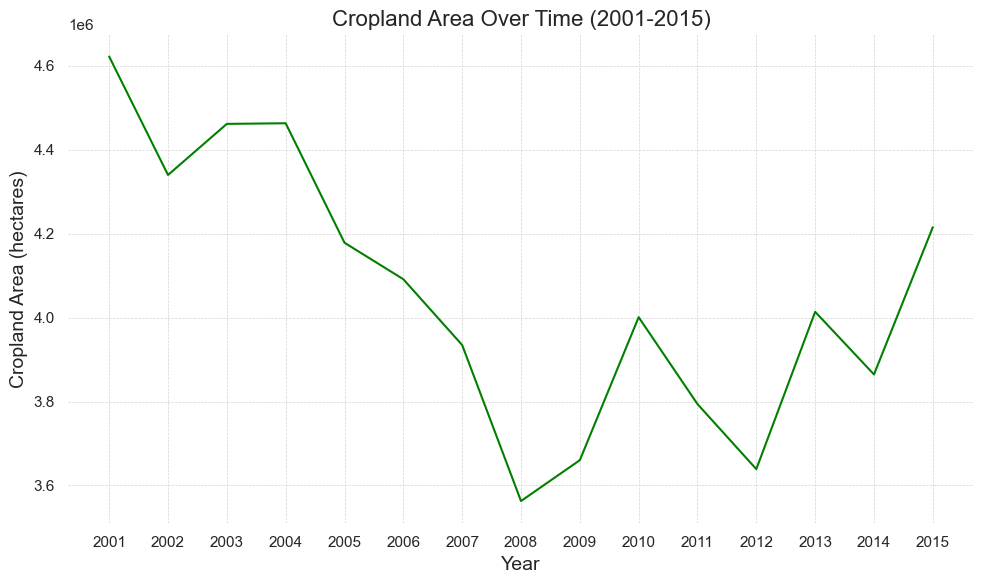

In [14]:
# Function to calculate cropland area for a specific year
# Define a function to get cropland area for a specific year
import seaborn as sns

# Set a seaborn style
sns.set_theme(style="whitegrid")


def get_cropland_area(year):
    # Load MODIS Land Cover dataset for the specified year
    modis_lc = (
        ee.ImageCollection("MODIS/061/MCD12Q1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("LC_Type2")
        .mosaic()
    )

    # Check if the image exists
    if modis_lc is None:
        raise ValueError(f"No land cover data found for the year {year}.")

    # Isolate cropland class (class 12 in MODIS IGBP classification)
    cropland = modis_lc.eq(12).clip(syria_geometry)

    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=500,  # MODIS resolution is 500 meters
        maxPixels=1e13,
    )

    # Extract the result from the dictionary and return it
    cropland_area_value = cropland_area.getInfo().get("LC_Type2") / 10000.0
    return cropland_area_value


# Years to calculate cropland areas (every 5th year from 2000 to 2022)
years = list(range(2001, 2016, 1))

# Calculate cropland areas for each year
cropland_areas = []
for year in years:
    try:
        area = get_cropland_area(year)
        cropland_areas.append(area)
        print(f"Cropland Area in {year}: {area:.2f} hectares")
    except Exception as e:
        print(f"Error calculating cropland area for {year}: {e}")
        cropland_areas.append(0)

# Plot the cropland areas
plt.figure(figsize=(10, 6))
plt.plot(years, cropland_areas, linestyle="-", color="green")
plt.title("Cropland Area Over Time (2001-2015)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Cropland Area (hectares)", fontsize=14)
# Customize legend
# plt.legend(title="State", loc="upper right", fontsize=12, title_fontsize=13)
# Add gridlines
plt.grid(visible=True, which="both", color="lightgray", linestyle="--", linewidth=0.5)
# plt.ylim(2.0,5.0)
# plt.grid(True)
plt.xticks(years)
# Remove all spines (plot boundaries)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
# plt.ylim(3.4, 4.8)
plt.tight_layout()
plt.show()

In [39]:
# Function to calculate cropland area for a specific year
# Define a function to get cropland area for a specific year
ee.Initialize()

# import seaborn as sns
import numpy as np

# Set a seaborn style
# sns.set_theme(style="whitegrid")


def get_cropland_area(year):
    # Load MODIS Land Cover dataset for the specified year
    dw_lc = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("label")
        .mosaic()
    )

    # Check if the image exists
    if dw_lc is None:
        raise ValueError(f"No land cover data found for the year {year}.")

    # Isolate cropland class (class 12 in MODIS IGBP classification)
    cropland = dw_lc.eq(4).clip(syria_geometry)

    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=100,  # MODIS resolution is 500 meters
        maxPixels=1e13,
    )

    print(cropland_area.getInfo())
    # Extract the result from the dictionary and return it
    cropland_area_value = cropland_area.getInfo().get("label") / 10000.0
    return cropland_area_value


# Years to calculate cropland areas (every 5th year from 2000 to 2022)
# years = [2015,2017,2019,2021,2023,2024]
years = list(range(2016, 2025, 1))

# Calculate cropland areas for each year
cropland_areas = []
for year in years:
    try:
        area = get_cropland_area(year)
        cropland_areas.append(area)
        print(f"Cropland Area in {year}: {area:.2f} hectares")
    except Exception as e:
        print(f"Error calculating cropland area for {year}: {e}")
        cropland_areas.append(0)

# Plot the cropland areas
plt.figure(figsize=(10, 6))
plt.plot(years, cropland_areas, linestyle="-", color="green")
plt.title("Cropland Area Over Time (2016-2024)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Cropland Area (hectares)", fontsize=14)
# plt.ylim(2, None)  # Set the range
# plt.yticks([2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50])  # Define the intervals
plt.grid(visible=True, which="both", color="lightgray", linestyle="--", linewidth=0.5)

# Remove all spines (plot boundaries)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)

plt.xticks(years)
plt.tight_layout()
plt.show()

{'label': 41133451671.701004}
Cropland Area in 2016: 4113345.17 hectares
{'label': 18857707489.95514}
Cropland Area in 2017: 1885770.75 hectares
{'label': 61130716681.436356}
Cropland Area in 2018: 6113071.67 hectares
{'label': 48828944115.243324}
Cropland Area in 2019: 4882894.41 hectares
{'label': 45162103731.722855}
Cropland Area in 2020: 4516210.37 hectares
{'label': 37204931176.16995}
Cropland Area in 2021: 3720493.12 hectares
{'label': 49132117959.633865}


KeyboardInterrupt: 

In [ ]:
# Define the years for comparison
start_year = 2010
end_year = 2022

# Define the region (e.g., Syria)
# syria_geometry = ee.Geometry.Polygon([[[36.0, 32.0], [42.0, 32.0], [42.0, 37.5], [36.0, 37.5], [36.0, 32.0]]])  # Adjust coordinates


# Define a function to get cropland area for a specific year
def get_cropland_area(year):
    # Load MODIS Land Cover dataset for the specified year
    modis_lc = (
        ee.ImageCollection("MODIS/061/MCD12Q1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("LC_Type2")
        .mosaic()
    )

    # Check if the image exists
    if modis_lc is None:
        raise ValueError(f"No land cover data found for the year {year}.")

    # Isolate cropland class (class 12 in MODIS IGBP classification)
    cropland = modis_lc.eq(12).clip(syria_geometry)

    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=500,  # MODIS resolution is 500 meters
        maxPixels=1e13,
    )

    # Extract the result from the dictionary and return it
    cropland_area_value = cropland_area.getInfo().get("LC_Type2") / 10000.0
    return cropland_area_value


# Calculate cropland area in start and end years
cropland_area_start = get_cropland_area(start_year)
cropland_area_end = get_cropland_area(end_year)
cropland_area_loss = cropland_area_start - cropland_area_end

print(f"Cropland Area in {start_year}: {cropland_area_start} hectares")
print(f"Cropland Area in {end_year}: {cropland_area_end} hectares")
print(f"Cropland Area Loss: {cropland_area_loss} hectares")

Cropland Area in 2001: 4621817.3448303845 hectares
Cropland Area in 2022: 2757490.8773882017 hectares
Cropland Area Loss: 1864326.4674421828 hectares


In [ ]:
"""# Define the years for comparison
start_year = 2020  # Dynamic World starts in 2020
end_year = 2024

# Define a function to get cropland area for a specific year using Dynamic World
def get_cropland_area_dynamic_world(year):
    # Load Dynamic World dataset for the specified year
    dynamic_world = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
        .filter(ee.Filter.calendarRange(year, year, "year")) \
        .select("label") \
        .mosaic()
    
    # Cropland class is labeled as 3 in the Dynamic World dataset
    cropland = dynamic_world.eq(3).clip(syria_geometry)
    
    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=10,  # Dynamic World has 10-meter resolution
        maxPixels=1e13
    )
    
    # Extract the result from the dictionary and return it in hectares
    cropland_area_value = cropland_area.getInfo().get("label") / 10000.0  # Convert from square meters to hectares
    return cropland_area_value

# Calculate cropland area in start and end years
cropland_area_start = get_cropland_area_dynamic_world(start_year)
cropland_area_end = get_cropland_area_dynamic_world(end_year)
cropland_area_loss = cropland_area_start - cropland_area_end

# Print results
print(f"Cropland Area in {start_year}: {cropland_area_start:.2f} hectares")
print(f"Cropland Area in {end_year}: {cropland_area_end:.2f} hectares")
print(f"Cropland Area Loss: {cropland_area_loss:.2f} hectares")"""

In [ ]:
# Load MODIS Land Cover dataset for pre-conflict and post-conflict years

pre_conflict_year = 2019
post_conflict_year = 2024

pre_conflict_landuse = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filter(ee.Filter.calendarRange(pre_conflict_year, pre_conflict_year, "year"))
    .mosaic()
    .clip(syria_geometry)
)

post_conflict_landuse = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filter(ee.Filter.calendarRange(post_conflict_year, post_conflict_year, "year"))
    .mosaic()
    .clip(syria_geometry)
)

# Define cropland class (class 12 in MODIS IGBP classification)
cropland_pre = pre_conflict_landuse.eq(12)
cropland_post = post_conflict_landuse.eq(12)

In [ ]:
# Load ACLED data as a GeoDataFrame
acled_data_path = os.path.join(
    base_path, "data", "2019-11-01-2024-11-01-Middle_East-Syria.csv"
)
acled_data = pd.read_csv(acled_data_path, parse_dates=["event_date"])
acled_gdf = gpd.GeoDataFrame(
    acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude)
)


# Convert GeoDataFrame to GEE FeatureCollection
def gdf_to_fc(gdf):
    """
    Converts a GeoDataFrame to a GEE FeatureCollection.
    """

    def row_to_feature(row):
        geom = ee.Geometry.Point([row["geometry"].x, row["geometry"].y])
        properties = row.drop(labels=["geometry"]).to_dict()
        return ee.Feature(geom, properties)

    features = [row_to_feature(row) for _, row in gdf.iterrows()]
    return ee.FeatureCollection(features)


# Convert the ACLED GeoDataFrame to a GEE FeatureCollection
acled_fc = gdf_to_fc(acled_gdf)

# Create a buffer around conflict points (e.g., 5 km buffer)
conflict_buffer = acled_fc.map(lambda f: f.buffer(5000))

# Visualize on a map
import geemap

Map = geemap.Map(center=[34.8, 38.0], zoom=6)
Map.addLayer(conflict_buffer, {"color": "red"}, "Conflict Impact Zone")
Map

In [ ]:
# Mask cropland areas in pre- and post-conflict images
cropland_pre_masked = cropland_pre.updateMask(cropland_pre).clip(region)
cropland_post_masked = cropland_post.updateMask(cropland_post).clip(region)

# Apply the conflict buffer mask
cropland_pre_conflict_area = cropland_pre_masked.updateMask(conflict_buffer)
cropland_post_conflict_area = cropland_post_masked.updateMask(conflict_buffer)

# Identify areas where cropland has changed due to conflict
cropland_loss = cropland_pre_conflict_area.And(
    cropland_post_conflict_area.Not()
)  # Cropland lost
cropland_gain = cropland_post_conflict_area.And(
    cropland_pre_conflict_area.Not()
)  # Cropland gained

In [ ]:
# Function to calculate cropland area for a specific year
# Define a function to get cropland area for a specific year
# Define a function to get cropland area for a specific year using Dynamic World
def get_cropland_area_dynamic_world(year):
    # Load Dynamic World dataset for the specified year
    dynamic_world = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("label")
        .mosaic()
    )

    # Cropland class is labeled as 3 in the Dynamic World dataset
    cropland = dynamic_world.eq(3).clip(syria_geometry)

    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=10,  # Dynamic World has 10-meter resolution
        maxPixels=1e13,
    )

    # Extract the result from the dictionary and return it in hectares
    cropland_area_value = (
        cropland_area.getInfo().get("label") / 10000.0
    )  # Convert from square meters to hectares
    return cropland_area_value

    # Extract the result from the dictionary and return it
    cropland_area_value = cropland_area.getInfo().get("LC_Type2") / 10000.0
    return cropland_area_value


# Years to calculate cropland areas (every 5th year from 2000 to 2022)
years = list(range(2022, 2025, 1))

# Calculate cropland areas for each year
cropland_areas = []
for year in years:
    try:
        area = get_cropland_area(year)
        cropland_areas.append(area)
        print(f"Cropland Area in {year}: {area:.2f} hectares")
    except Exception as e:
        print(f"Error calculating cropland area for {year}: {e}")
        cropland_areas.append(0)

# Plot the cropland areas
plt.figure(figsize=(10, 6))
plt.plot(years, cropland_areas, marker="o", linestyle="-", color="green")
plt.title("Cropland Area Over Time (2000-2022)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Cropland Area (hectares)", fontsize=14)
plt.grid(True)
plt.xticks(years)
plt.tight_layout()
plt.show()

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Initialize Google Earth Engine
ee.Initialize()

# Define the time range and region of interest (ROI)
start_year = 2011
end_year = 2023
syria_geometry = ee.Geometry.Polygon(
    [
        [
            [35.6191, 33.5092],
            [42.3748, 33.5092],
            [42.3748, 37.3190],
            [35.6191, 37.3190],
            [35.6191, 33.5092],
        ]
    ]
)  # Replace with your actual AOI

# Load the MODIS or Dynamic World dataset (choose one)
lc_collection = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")  # Dynamic World
# lc_collection = ee.ImageCollection("MODIS/061/MCD12Q1")  # Uncomment if using MODIS LC_Type2


# Filter the collection for each year and mask croplands
def get_cropland_area(year):
    yearly_image = (
        lc_collection.filterDate(f"{year}-01-01", f"{year}-12-31")
        .select("label")
        .mode()
    )  # Get the most common land cover class for the year
    cropland = yearly_image.eq(4)  # Croplands (Dynamic World class 4)
    cropland_area = cropland.multiply(ee.Image.pixelArea())  # Calculate area in m²
    total_area = cropland_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=10,  # Adjust scale to dataset resolution
        maxPixels=1e13,
    )
    return total_area.get("label"), cropland.clip(syria_geometry)


# Get cropland areas for all years
years = list(range(start_year, end_year + 1))
cropland_areas = []
cropland_maps = []

for year in years:
    area, cropland_map = get_cropland_area(year)
    cropland_areas.append(area)
    cropland_maps.append(cropland_map)

# Convert areas to square kilometers
cropland_areas_km2 = (
    ee.List(cropland_areas).map(lambda area: ee.Number(area).divide(1e6)).getInfo()
)

# Calculate cropland change (last year - first year)
cropland_first = cropland_maps[0]
cropland_last = cropland_maps[-1]
change_map = cropland_last.subtract(cropland_first)

# Visualize in Google Earth Engine Map
Map = geemap.Map()
Map.centerObject(syria_geometry, 6)

# Visualize the change map
change_palette = ["red", "gray", "green"]  # Red = loss, Gray = no change, Green = gain
Map.addLayer(
    change_map,
    {"min": -1, "max": 1, "palette": change_palette},
    "Cropland Change (2011-2023)",
)

# Visualize the cropland map for the last year
cropland_palette = ["white", "green"]  # White = non-cropland, Green = cropland
Map.addLayer(
    cropland_last,
    {"min": 0, "max": 1, "palette": cropland_palette},
    f"Cropland {end_year}",
)

# Add the map to display
Map.add_legend(
    title="Cropland Change",
    legend_dict={"Cropland Loss": "red", "No Change": "gray", "Cropland Gain": "green"},
)
Map

# Plot cropland area as a time series
plt.figure(figsize=(10, 6))
plt.plot(years, cropland_areas_km2, marker="o", linestyle="-", color="green")
plt.title("Cropland Area Over Time")
plt.xlabel("Year")
plt.ylabel("Cropland Area (km²)")
plt.grid()
plt.show()

In [37]:
import ee
import matplotlib.pyplot as plt

# Initialize Google Earth Engine
ee.Initialize()

# Define the years for comparison
start_year = 2015
end_year = 2022

# Define the region (e.g., Syria)
"""syria_geometry = ee.Geometry.Polygon([
    [[36.0, 32.0], [42.0, 32.0], [42.0, 37.5], [36.0, 37.5], [36.0, 32.0]]
])  # Adjust coordinates"""


# Function to get cropland area for a specific year
def get_cropland_area(year):
    # Load MODIS Land Cover dataset for the specified year
    modis_lc = (
        ee.ImageCollection("MODIS/061/MCD12Q1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("LC_Type2")
        .mosaic()
    )

    # Isolate cropland class (class 12 in MODIS IGBP classification)
    cropland = modis_lc.eq(12).clip(syria_geometry)

    # Calculate the area of cropland in square meters
    pixel_area = cropland.multiply(ee.Image.pixelArea())
    cropland_area = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=syria_geometry,
        scale=500,  # MODIS resolution is 500 meters
        maxPixels=1e13,
    )

    # Extract the result from the dictionary and convert to hectares
    cropland_area_value = cropland_area.get("LC_Type2").getInfo()
    return cropland_area_value / 10000.0  # Convert m² to hectares


# Calculate cropland area for each year and store results
years = list(range(start_year, end_year + 1))
cropland_areas = []

"""for year in years:
    area = get_cropland_area(year)
    cropland_areas.append(area)
    print(f"Year: {year}, Cropland Area: {area} hectares")

# Plot time series of cropland area
plt.figure(figsize=(10, 6))
plt.plot(years, cropland_areas, marker='o', linestyle='-', color='green')
plt.title("Cropland Area Over Time (2010-2022)")
plt.xlabel("Year")
plt.ylabel("Cropland Area (hectares)")
plt.grid()
plt.show()"""


# Create a change map between start_year and end_year
def get_cropland_map(year):
    modis_lc = (
        ee.ImageCollection("MODIS/061/MCD12Q1")
        .filter(ee.Filter.calendarRange(year, year, "year"))
        .select("LC_Type2")
        .mosaic()
    )
    cropland = modis_lc.eq(12).clip(syria_geometry)
    return cropland


# Generate cropland maps for start and end years
cropland_map_start = get_cropland_map(start_year)
cropland_map_end = get_cropland_map(end_year)

# Calculate cropland change (gain, loss, or no change)
change_map = cropland_map_end.subtract(cropland_map_start)

# Visualize the change map using geemap
import geemap

Map = geemap.Map()
Map.centerObject(syria_geometry, 6)

# Define visualization parameters
change_viz_params = {
    "min": -1,
    "max": 1,
    "palette": [
        "#ca3435",
        "#fef0d9",
        "#669d5b",
    ],  # Red: Loss, Gray: No Change, Green: Gain
}

# Add layers to the map
Map.addLayer(change_map, change_viz_params, "Cropland Change (2015-2022)")
# Map.addLayer(cropland_map_start, {'palette': ['white', 'green'], 'min': 0, 'max': 1}, f'Cropland {start_year}')
# Map.addLayer(cropland_map_end, {'palette': ['white', 'green'], 'min': 0, 'max': 1}, f'Cropland {end_year}')

# Define the legend with colors as tuples
legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",  # Red (loss)
    "No Change": "#fef0d9",  # Gray (no change)
}

Map.add_legend(title="Cropland Change", legend_dict=legend_dict)

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [20]:
# Print value distributions for cropland maps
print("Cropland Map Start (2010):")
cropland_map_start_values = cropland_map_start.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=syria_geometry,
    scale=500,
    maxPixels=1e13,
).getInfo()
print(cropland_map_start_values)

print("Cropland Map End (2022):")
cropland_map_end_values = cropland_map_end.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=syria_geometry,
    scale=500,
    maxPixels=1e13,
).getInfo()
print(cropland_map_end_values)

Cropland Map Start (2010):
{'LC_Type2': {'0': 723255.6352941195, '1': 197816.1333333332}}
Cropland Map End (2022):
{'LC_Type2': {'0': 785133.4392156887, '1': 135865.3294117649}}


In [21]:
# Print value distribution for the change map
print("Change Map (2010-2022):")
change_map_values = change_map.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=syria_geometry,
    scale=500,
    maxPixels=1e13,
).getInfo()
print(change_map_values)

Change Map (2010-2022):
{'LC_Type2': {'-1': 68669.35294117646, '0': 845597.8666666675, '1': 6718.549019607844}}


In [36]:
import ee
import geemap
import matplotlib.pyplot as plt

# Initialize Google Earth Engine
ee.Initialize()

# Define the years for comparison
start_year = 2015
end_year = 2024

# Define the region (e.g., Syria)
"""syria_geometry = ee.Geometry.Polygon([
    [[36.0, 32.0], [42.0, 32.0], [42.0, 37.5], [36.0, 37.5], [36.0, 32.0]]
])  # Adjust coordinates as needed"""


# Function to get cropland map for a specific year using Dynamic World
def get_cropland_map(year):
    # Load Dynamic World dataset for the specified year
    dynamic_world = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filter(ee.Filter.date(f"{year}-01-01", f"{year}-12-31"))
        .select("label")
        .mosaic()
    )

    # Cropland class is labeled as 3 in the Dynamic World dataset
    cropland = dynamic_world.eq(3).clip(syria_geometry)
    return cropland


# Generate cropland maps for start and end years
cropland_map_start = get_cropland_map(start_year)
cropland_map_end = get_cropland_map(end_year)

# Calculate cropland change (gain, loss, or no change)
change_map = cropland_map_end.subtract(cropland_map_start)

# Visualize the change map using geemap
Map = geemap.Map()
Map.centerObject(syria_geometry, 6)

# Define visualization parameters
change_viz_params = {
    "min": -1,
    "max": 1,
    "palette": [
        "#ca3435",
        "#fef0d9",
        "#669d5b",
    ],  # Red: Loss, Gray: No Change, Green: Gain
}

# Add layers to the map
Map.addLayer(change_map, change_viz_params, "Cropland Change (2015-2022)")
# Map.addLayer(cropland_map_start, {'palette': ['#f2f2f2', '#669d5b'], 'min': 0, 'max': 1}, f'Cropland {start_year}')
# Map.addLayer(cropland_map_end, {'palette': ['#f2f2f2', '#669d5b'], 'min': 0, 'max': 1}, f'Cropland {end_year}')

# Define the legend with colors as tuples
legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",  # Red (loss)
    "No Change": "#fef0d9",  # Gray (no change)
}

Map.add_legend(title="Cropland Change", legend_dict=legend_dict)

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [33]:
change_viz_params = {
    "min": -1,
    "max": 1,
    "palette": ["#d73027", "#fef0d9", "#1a9850"],  # Red, beige, green
    "opacity": 0.7,
}

# Initialize map
Map = geemap.Map()
Map.add_basemap("CartoDB Positron")  # Use a high-contrast basemap
Map.centerObject(syria_geometry, 7)

# Add cropland change layer
Map.addLayer(change_map, change_viz_params, "Cropland Change (2015-2022)")

# Add legend
legend_dict = {
    "Cropland Gain": "#1a9850",
    "Cropland Loss": "#d73027",
    "No Change": "#fef0d9",
}
Map.add_legend(title="<b>Cropland Change</b>", legend_dict=legend_dict)

# Display the map
Map

Basemap can only be one of the following:
  OpenStreetMap
  Esri.WorldStreetMap
  Esri.WorldImagery
  Esri.WorldTopoMap
  FWS NWI Wetlands
  FWS NWI Wetlands Raster
  NLCD 2021 CONUS Land Cover
  NLCD 2019 CONUS Land Cover
  NLCD 2016 CONUS Land Cover
  NLCD 2013 CONUS Land Cover
  NLCD 2011 CONUS Land Cover
  NLCD 2008 CONUS Land Cover
  NLCD 2006 CONUS Land Cover
  NLCD 2004 CONUS Land Cover
  NLCD 2001 CONUS Land Cover
  USGS NAIP Imagery
  USGS NAIP Imagery False Color
  USGS NAIP Imagery NDVI
  USGS Hydrography
  USGS 3DEP Elevation
  ESA Worldcover 2020
  ESA Worldcover 2020 S2 FCC
  ESA Worldcover 2020 S2 TCC
  ESA Worldcover 2021
  ESA Worldcover 2021 S2 FCC
  ESA Worldcover 2021 S2 TCC
  BaseMapDE.Color
  BaseMapDE.Grey
  BasemapAT.basemap
  BasemapAT.grau
  BasemapAT.highdpi
  BasemapAT.orthofoto
  BasemapAT.overlay
  BasemapAT.surface
  BasemapAT.terrain
  CartoDB.DarkMatter
  CartoDB.DarkMatterNoLabels
  CartoDB.DarkMatterOnlyLabels
  CartoDB.Positron
  CartoDB.PositronNoLa

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [39]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
# Map

In [40]:
region = syria_geometry

In [41]:
Map.centerObject(region)

In [42]:
# Set the date range
start_date = "2015-01-01"
end_date = "2024-10-31"

In [43]:
images = geemap.dynamic_world_timeseries(
    region, start_date, end_date, return_type="class"
)

In [44]:
vis_params = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}
Map.addLayer(images.first(), vis_params, "First image")
Map.add_legend(title="Dynamic World Land Cover", builtin_legend="Dynamic_World")
Map

Map(center=[34.817790985000045, 38.999490738000056], controls=(WidgetControl(options=['position', 'transparent…

In [45]:
Map.ts_inspector(images, left_vis=vis_params, date_format="YYYY")

In [46]:
Map = geemap.Map()
Map.add_basemap("HYBRID")
Map.centerObject(region)

images = geemap.dynamic_world_timeseries(
    region, start_date, end_date, return_type="hillshade"
)
Map.ts_inspector(images, date_format="YYYY")
Map.add_legend(title="Dynamic World Land Cover", builtin_legend="Dynamic_World")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(layout=Layo…

In [47]:
ppl_gdf = gpd.read_file(
    os.path.join(
        base_path, "data", "boundaries", "syr_pplp_humanitarian_location_unocha.shp"
    )
)
ppl_gdf

,OBJECTID,admin0Name,admin0Na_1,admin0Pcod,admin1Name,admin1Na_1,admin1Pcod,admin2Name,admin2Na_1,admin2Pcod,...,Location_1,Location_P,location_t,LastUpdate,Latitude_y,Longitude_,Hosting_in,is_Admin1_,is_Admin_3,geometry
0,1,Syrian Arab Republic,الجمهورية العربية السورية,SY,Idleb,إدلب,SY07,Ariha,أريحا,SY0705,...,الكفير - مركز أريحا,C8380,Community,18/08/2020,35.839891,36.500225,No,No,No,POINT (36.50023 35.83989)
1,2,Syrian Arab Republic,الجمهورية العربية السورية,SY,Idleb,إدلب,SY07,Ariha,أريحا,SY0705,...,الملجأ,C8381,Community,18/08/2020,35.776098,36.602760,No,No,No,POINT (36.60276 35.7761)
2,3,Syrian Arab Republic,الجمهورية العربية السورية,SY,Idleb,إدلب,SY07,Ariha,أريحا,SY0705,...,سيغاتا - مركز أريحا,C8382,Community,18/08/2020,35.730155,36.648506,No,No,No,POINT (36.64851 35.73016)
3,4,Syrian Arab Republic,الجمهورية العربية السورية,SY,Idleb,إدلب,SY07,Ariha,أريحا,SY0705,...,القنفد,C8383,Community,18/08/2020,35.798922,36.417307,No,No,No,POINT (36.41731 35.79892)
4,5,Syrian Arab Republic,الجمهورية العربية السورية,SY,Idleb,إدلب,SY07,Ariha,أريحا,SY0705,...,سد حيلا,C8384,Community,18/08/2020,35.852396,36.495533,No,No,No,POINT (36.49553 35.8524)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8359,8360,Syrian Arab Republic,الجمهورية العربية السورية,SY,As-Sweida,السويداء,SY13,Shahba,شهبا,SY1303,...,الصورة الصغيرة,C6259,Community,19/12/2018,33.033873,36.573366,No,None,Yes,POINT (36.57337 33.03387)
8360,8361,Syrian Arab Republic,الجمهورية العربية السورية,SY,Quneitra,القنيطرة,SY14,Quneitra,مركز القنيطرة,SY1400,...,القنيطرة - مركز القنيطرة,C6268,Community,19/12/2018,33.124215,35.826407,No,Yes,Yes,POINT (35.82641 33.12422)
8361,8362,Syrian Arab Republic,الجمهورية العربية السورية,SY,Quneitra,القنيطرة,SY14,Quneitra,مركز القنيطرة,SY1400,...,خان أرنبة,C6273,Community,19/12/2018,33.182075,35.890832,No,None,Yes,POINT (35.89083 33.18208)
8362,8363,Syrian Arab Republic,الجمهورية العربية السورية,SY,Quneitra,القنيطرة,SY14,Quneitra,مركز القنيطرة,SY1400,...,القصيبة - الخشنية,C6290,Community,19/12/2018,32.979807,35.958632,No,None,Yes,POINT (35.95863 32.97981)


In [48]:
ppl_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
ppl_gdf = ppl_gdf.to_crs(epsg=32636)

In [67]:
ppl_gdf["geometry"] = ppl_gdf.geometry.buffer(5000)
ppl_gdf
ppl_gdf.to_file(os.path.join(base_path, "data", "boundaries", "syr_admin4.shp"))

In [58]:
# Define the years for comparison
start_year = 2015
end_year = 2024

# admin4_gdf = ppl_gdf
admin2_gdf = gpd.read_file(
    os.path.join(base_path, "data", "boundaries", "syr_admin2.shp")
)

# Convert the shapefile to Earth Engine format
admin2_fc = gpd_to_gee(admin2_gdf)

In [59]:
# Function to get cropland map for a specific year using Dynamic World
def get_cropland_map(year):
    # Load Dynamic World dataset for the specified year
    dynamic_world = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filter(ee.Filter.date(f"{year}-01-01", f"{year}-12-31"))
        .select("label")
        .mosaic()
    )

    # Cropland class is labeled as 3 in the Dynamic World dataset
    cropland = dynamic_world.eq(4)
    return cropland


# Generate cropland maps for start and end years
cropland_map_start = get_cropland_map(start_year)
cropland_map_end = get_cropland_map(end_year)

# Calculate cropland change (gain, loss, or no change)
cropland_gain = cropland_map_end.And(cropland_map_start.Not())  # Gain
cropland_loss = cropland_map_start.And(cropland_map_end.Not())  # Loss

"""# Aggregate cropland gain and loss to admin4 level
gain_stats = cropland_gain.multiply(ee.Image.pixelArea()).reduceRegions(
    collection=admin4_fc,
    reducer=ee.Reducer.sum(),
    scale=10
)

loss_stats = cropland_loss.multiply(ee.Image.pixelArea()).reduceRegions(
    collection=admin4_fc,
    reducer=ee.Reducer.sum(),
    scale=10
)"""

# Map visualization
Map = geemap.Map()
Map.centerObject(admin2_fc, 6)

# Define visualization parameters
gain_viz_params = {"palette": "#669d5b", "opacity": 0.6}  # Green: Gain
loss_viz_params = {"palette": "#ca3435", "opacity": 0.6}  # Red: Loss

# Add layers to the map
Map.addLayer(cropland_gain, gain_viz_params, "Cropland Gain")
Map.addLayer(cropland_loss, loss_viz_params, "Cropland Loss")

# Add the admin4 boundaries
Map.addLayer(admin2_fc, {}, "Admin4 Boundaries")

# Define the legend with colors as tuples
legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",  # Red (loss)
}

Map.add_legend(title="Cropland Change (2015-2024)", legend_dict=legend_dict)

# Display the map
Map

Map(center=[35.00473779849404, 38.49054489196505], controls=(WidgetControl(options=['position', 'transparent_b…

In [10]:
# Combine cropland gain and loss into a single layer
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))

# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [11]:
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))

# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "#040303",
        "#669d5b",
        "#ca3435",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    "No change": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)

# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Change"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2015–2023)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
dw = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filterBounds(syria_geometry)
    .select("label")
)

# Define before and after years
before_year = 2016
after_year = 2023

# Define the start and end dates for before and after periods
before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, "year")
after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, "year")

# Create mean composites and filter for cropland (label == 4)
before_dw = dw.filterDate(before_start, before_end).mean().eq(4)
after_dw = dw.filterDate(after_start, after_end).mean().eq(4)

# Calculate cropland gain and loss
cropland_gain = before_dw.lt(0.2).And(after_dw.gt(0.5))
cropland_loss = before_dw.gt(0.5).And(after_dw.lt(0.2))

In [19]:
# Combine cropland gain and loss into a single layer
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))

# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    "No change": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)


# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2016–2023)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [9]:
dw = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filterBounds(syria_geometry)
    .select("label")
)

# Define before and after years
before_year = 2016
after_year = 2023

# Define the start and end dates for before and after periods
before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, "year")
after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, "year")

# Create mean composites and filter for cropland (label == 4)
before_dw = dw.filterDate(before_start, before_end).mosaic().eq(4)
after_dw = dw.filterDate(after_start, after_end).mosaic().eq(4)

# Calculate cropland gain and loss
cropland = before_dw.eq(1)
cropland_gain = before_dw.eq(0).And(after_dw.eq(1))  # Areas that became cropland
cropland_loss = before_dw.eq(1).And(after_dw.eq(0))
# Combine cropland gain and loss into a single layer
# combined_layer = cropland.multiply(1).add(cropland_gain.multiply(2)).add(cropland_loss.multiply(3))
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))
# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    #'No change in cropland': '#3028d1',
    "No change": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)


# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2016–2023)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

# Map.save('dw_lcluc_2024_map.html')

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [8]:
dw = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filterBounds(syria_geometry)
    .select("label")
)

# Define before and after years
before_year = 2016
after_year = 2024

# Define the start and end dates for before and after periods
before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, "year")
after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(10, "month")

# Create mean composites and filter for cropland (label == 4)
before_dw = dw.filterDate(before_start, before_end).mosaic().eq(4)
after_dw = dw.filterDate(after_start, after_end).mosaic().eq(4)

# Calculate cropland gain and loss
# cropland = before_dw.eq(1)
cropland_gain = before_dw.eq(0).And(after_dw.eq(1))  # Areas that became cropland
cropland_loss = before_dw.eq(1).And(after_dw.eq(0))
# Combine cropland gain and loss into a single layer
# combined_layer = cropland.multiply(1).add(cropland_gain.multiply(2)).add(cropland_loss.multiply(3))
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))
# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    #'No change in cropland': '#3028d1',
    "No change": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)


# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2016–2024)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

# Map.save('dw_lcluc_2024_map.html')

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
dw = (
    ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    .filterBounds(syria_geometry)
    .select("label")
)

# Define before and after years
before_year = 2023
after_year = 2024

# Define the start and end dates for before and after periods
before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, "year")
after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(10, "month")

# Create mean composites and filter for cropland (label == 4)
before_dw = dw.filterDate(before_start, before_end).mode().eq(4)
after_dw = dw.filterDate(after_start, after_end).mode().eq(4)

# Calculate cropland gain and loss
cropland = before_dw.eq(1)
cropland_gain = before_dw.eq(0).And(after_dw.eq(1))  # Areas that became cropland
cropland_loss = before_dw.eq(1).And(after_dw.eq(0))
# Combine cropland gain and loss into a single layer
# combined_layer = cropland.multiply(1).add(cropland_gain.multiply(2)).add(cropland_loss.multiply(3))
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))
# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    "No change in cropland": "#3028d1",
    "Non cropland": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)


# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2023–2024)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

# Map.save('dw_lcluc_2024_map.html')

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…

In [11]:
modis_lc = (
    ee.ImageCollection("MODIS/061/MCD12Q1")
    .filterBounds(syria_geometry)
    .select("LC_Type2")
)


# Define before and after years
before_year = 2010
after_year = 2011

# Define the start and end dates for before and after periods
before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, "year")
after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, "year")

# Create mean composites and filter for cropland (label == 4)
before_lc = modis_lc.filterDate(before_start, before_end).mosaic().eq(12)
after_lc = modis_lc.filterDate(after_start, after_end).mosaic().eq(12)

# Calculate cropland gain and loss
cropland = before_lc.eq(1)
cropland_gain = before_lc.eq(0).And(after_lc.eq(1))  # Areas that became cropland
cropland_loss = before_lc.eq(1).And(after_lc.eq(0))
# Combine cropland gain and loss into a single layer
# combined_layer = cropland.multiply(1).add(cropland_gain.multiply(2)).add(cropland_loss.multiply(3))
combined_layer = cropland_gain.multiply(1).add(cropland_loss.multiply(2))


# Define visualization parameters
combined_vis_params = {
    "min": 0,
    "max": 2,
    "palette": [
        "black",
        "green",
        "red",
    ],  # Black for no change, green for gain, red for loss
}

# Create a map to visualize the results
Map = geemap.Map()
Map.centerObject(syria_geometry, 8)

legend_dict = {
    "Cropland Gain": "#669d5b",  # Green (gain)
    "Cropland Loss": "#ca3435",
    #'No change in cropland': '#3028d1',
    "No change": "#040303",
}

Map.add_legend(legend_title="Cropland Change", legend_dict=legend_dict)


# Add the combined layer to the map
Map.addLayer(
    combined_layer.clip(syria_geometry), combined_vis_params, "Cropland Gain and Loss"
)

Map.add_text(
    x=0.5,  # Horizontal position (fraction of the map width)
    y=0.95,  # Vertical position (fraction of the map height)
    text="Cropland Change in Syria (2010–2011)",
    fontsize=18,
    fontcolor="black",
    bgcolor="white",
    borderwidth=1,
    bordercolor="black",
)

Map.save("modis_lcluc_2011_map.html")

# Display the map
Map

Map(center=[35.00473784303623, 38.49054487731182], controls=(WidgetControl(options=['position', 'transparent_b…